# KNMI data visualization

<em>TODO: WRITE INTRODUCTION (LATER)</em>

In the [previous Notebook in the series](./01-knmi_data_retrieval.ipynb) we dived into some examples for data retrieval from the KNMI web script service. In this notebook we will build upon the gained knowledge and delve into examples of data analysis.

### Disclaimer
I am not officially affiliated with KNMI, and the scripts and insights provided in this Jupyter Notebook are offered on an unofficial basis for educational and exploratory purposes.

## Preparation steps
We will start by importing the required external and internal modules, scripts and libraries.

### Import external libraries
Note: these are only the external libraries used directly within this Notebook. The Python helper scripts, imported in the subsequent step, may require the installation of additional libraries.

In [1]:
import datetime
import numpy as np
import pandas as pd

from functools import partial, reduce


### Internal imports
In the code below the custom Python helper scripts powering the workflow in this Jupyter Notebook are imported.

In [2]:
import knmi_meteo_ingest
import knmi_meteo_transform
import knmi_meteo_visualize

## Section 1 - Parameter-based hour slot occurrences

### Example 1.1: Summarize occurrences of rainiest hour slots throughout The Netherlands for a selection of years

#### Obtain the raw dataset from KNMI service

In [3]:
# Set year as variable
YEAR = 2023

In [4]:
# Set start and end dates (inclusive) for data retrieval
start_date = datetime.date(YEAR, 1, 1)
end_date = datetime.date(YEAR, 12, 31)

# Optional: uncomment below to make end_date exclusive
# end_date -= datetime.timedelta(days=1)

In [5]:
# Get dataset from KNMI web script service
df_day = knmi_meteo_ingest.knmi_meteo_to_df(meteo_stns_list=None,
                                            meteo_params_list=None,
                                            start_date=start_date,
                                            end_date=end_date)

#### Clean (transform) dataset
We can improve the readibility of the dataset by applying some preset transformations on the "raw" dataset we just ingested. 

As part of this transformation, all parameters are converted to whole units of measurements (e.g. m/s, J/cm2, °C) for better interpretability. Furthermore the column names are converted to a more readable format.

In [6]:
# Apply transformations to the raw dataset
df_day_cleaned = knmi_meteo_transform.transform_param_values(df_day)

In [7]:
# Show the result
df_day_cleaned

,station_code,date,vect_avg_wind_dir,vect_avg_wind_speed,day_avg_wind_speed,max_hour_avg_wind_speed,hour_slot_max_avg_wind_speed,min_hour_avg_wind_speed,hour_slot_min_avg_wind_speed,max_gust_speed,...,hour_slot_min_visibility,max_visibility_cat,hour_slot_min_visibility,cloudiness_in_eights_cat,day_avg_humidity,max_humidity,hour_slot_max_humidity,min_humidity,hour_slot_min_humidity,evap_ref
0,209,2023-01-01,215.0,9.2,9.6,14.0,1.0,3.0,22.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,209,2023-01-02,266.0,6.1,6.9,8.0,2.0,5.0,1.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,209,2023-01-03,196.0,8.3,8.8,15.0,22.0,3.0,3.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,209,2023-01-04,233.0,13.7,14.1,17.0,2.0,12.0,18.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,209,2023-01-05,245.0,8.2,9.0,12.0,2.0,6.0,13.0,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17150,391,2023-12-27,176.0,2.7,3.1,5.0,18.0,1.0,1.0,11.0,...,NaN,NaN,NaN,NaN,0.82,0.95,1.0,0.53,21.0,0.2
17151,391,2023-12-28,225.0,4.8,4.8,6.0,11.0,4.0,1.0,13.0,...,NaN,NaN,NaN,NaN,0.72,0.79,4.0,0.67,17.0,0.3
17152,391,2023-12-29,236.0,4.9,5.0,6.0,1.0,4.0,13.0,15.0,...,NaN,NaN,NaN,NaN,0.81,0.92,13.0,0.72,1.0,0.1
17153,391,2023-12-30,213.0,3.0,3.5,5.0,1.0,3.0,6.0,9.0,...,NaN,NaN,NaN,NaN,0.80,0.87,8.0,0.73,14.0,0.3


#### Summarize dataset

In [8]:
# Get distribution overview of numeric cols
df_day_cleaned.describe().T

,count,mean,std,min,25%,50%,75%,max
station_code,17155.0,297.361702,46.271796,209.00,260.00,286.00,331.000,391.00
vect_avg_wind_dir,16741.0,187.695657,91.645513,1.00,110.00,212.00,249.000,360.00
vect_avg_wind_speed,16741.0,4.629096,2.760371,0.10,2.60,4.10,6.100,17.60
day_avg_wind_speed,16744.0,5.240952,2.699477,0.40,3.30,4.70,6.700,18.20
max_hour_avg_wind_speed,16741.0,7.685264,3.343342,1.00,5.00,7.00,10.000,30.00
hour_slot_max_avg_wind_speed,16741.0,10.907353,6.365938,1.00,6.00,11.00,15.000,24.00
min_hour_avg_wind_speed,16741.0,2.782331,2.251414,0.00,1.00,2.00,4.000,15.00
hour_slot_min_avg_wind_speed,16741.0,9.724509,8.549831,1.00,1.00,6.00,19.000,24.00
max_gust_speed,16742.0,12.056146,4.514247,2.00,9.00,11.00,15.000,41.00
hour_slot_max_gust_speed,16742.0,11.755167,6.309347,1.00,7.00,12.00,16.000,24.00


- Which time(s) of the day tended to be the rainiest/sunniest?
- Which of the measured locations were most/least windy?
- What were the total sums for rainfall and sunshine for the year of interest, and how did this vary throughout The Netherlands?
- Where and when did we see extreme rainfall or drought?
- At what time of the day did we typically see the lowest and highest temperatures, and is there a difference per region?

In [9]:
# TODO: Make boxplot of distribution of hour_slot_max_rain_hour_sum (to show all stations' distributions in one go)
sel_cols = ["date", "station_code", "max_rain_hour_sum",
            "hour_slot_max_rain_hour_sum"]

df_max_rain_h = df_day_cleaned[sel_cols]

In [10]:
# Show the result
df_max_rain_h

,date,station_code,max_rain_hour_sum,hour_slot_max_rain_hour_sum
0,2023-01-01,209,NaN,NaN
1,2023-01-02,209,NaN,NaN
2,2023-01-03,209,NaN,NaN
3,2023-01-04,209,NaN,NaN
4,2023-01-05,209,NaN,NaN
...,...,...,...,...
17150,2023-12-27,391,1.7,8.0
17151,2023-12-28,391,0.0,1.0
17152,2023-12-29,391,5.0,20.0
17153,2023-12-30,391,0.0,1.0


In [11]:
is_dry = df_max_rain_h["max_rain_hour_sum"] < 0.1

df_max_rain_h.loc[is_dry,
                  "hour_slot_max_rain_hour_sum"] = -1

df_max_rain_h

,date,station_code,max_rain_hour_sum,hour_slot_max_rain_hour_sum
0,2023-01-01,209,NaN,NaN
1,2023-01-02,209,NaN,NaN
2,2023-01-03,209,NaN,NaN
3,2023-01-04,209,NaN,NaN
4,2023-01-05,209,NaN,NaN
...,...,...,...,...
17150,2023-12-27,391,1.7,8.0
17151,2023-12-28,391,0.0,-1.0
17152,2023-12-29,391,5.0,20.0
17153,2023-12-30,391,0.0,-1.0


In [12]:
# Remove "max_rain_hour_sum" column
drop_cols = ["max_rain_hour_sum"]
df_max_rain_h = df_max_rain_h.drop(columns=drop_cols)

In [13]:
# Show the result
df_max_rain_h

,date,station_code,hour_slot_max_rain_hour_sum
0,2023-01-01,209,NaN
1,2023-01-02,209,NaN
2,2023-01-03,209,NaN
3,2023-01-04,209,NaN
4,2023-01-05,209,NaN
...,...,...,...
17150,2023-12-27,391,8.0
17151,2023-12-28,391,-1.0
17152,2023-12-29,391,20.0
17153,2023-12-30,391,-1.0


In [14]:
# Pivot data with 'date' as index, 'stn_code' as cols
df_max_rain_h_pivot = (df_max_rain_h
                       .pivot(index="date",
                              columns="station_code"))

# Flatten pivot table to single index
df_max_rain_h_pivot.columns = (df_max_rain_h_pivot.columns
                               .get_level_values(1))

In [15]:
df_max_rain_h_pivot

station_code,209,215,225,235,240,242,248,249,251,257,...,343,344,348,350,356,370,375,377,380,391
date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,NaN,21.0,NaN,22.0,21.0,NaN,NaN,21.0,21.0,20.0,...,NaN,20.0,20.0,19.0,20.0,8.0,9.0,19.0,17.0,19.0
2023-01-02,NaN,5.0,NaN,4.0,14.0,NaN,NaN,5.0,2.0,4.0,...,NaN,3.0,16.0,6.0,17.0,7.0,7.0,8.0,17.0,8.0
2023-01-03,NaN,24.0,NaN,24.0,24.0,NaN,NaN,24.0,18.0,24.0,...,NaN,24.0,24.0,24.0,24.0,24.0,9.0,9.0,-1.0,9.0
2023-01-04,NaN,1.0,NaN,3.0,8.0,NaN,NaN,6.0,3.0,6.0,...,NaN,8.0,10.0,1.0,1.0,13.0,2.0,16.0,13.0,14.0
2023-01-05,NaN,16.0,NaN,18.0,16.0,NaN,NaN,18.0,19.0,16.0,...,NaN,16.0,16.0,16.0,16.0,20.0,17.0,16.0,16.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,NaN,8.0,NaN,10.0,9.0,NaN,NaN,9.0,12.0,9.0,...,NaN,8.0,8.0,6.0,8.0,6.0,8.0,6.0,7.0,8.0
2023-12-28,NaN,23.0,NaN,22.0,22.0,NaN,NaN,-1.0,19.0,22.0,...,NaN,23.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2023-12-29,NaN,17.0,NaN,-1.0,16.0,NaN,NaN,2.0,22.0,10.0,...,NaN,15.0,15.0,14.0,23.0,13.0,14.0,16.0,8.0,20.0


In [16]:
# Only keep cols if less than fraction of values missing
max_na_frac = 0.1

# Select columns to keep (using the condition)
keep_cols = [col for col in df_max_rain_h_pivot.columns 
             if (df_max_rain_h_pivot[col].isna().sum() 
                 <= max_na_frac * len(df_max_rain_h_pivot))]

# Apply selection to our DataFrame
df_max_rain_h_pivot = df_max_rain_h_pivot[keep_cols]

In [17]:
df_max_rain_h_pivot

station_code,215,235,240,249,251,257,260,267,269,270,...,340,344,348,350,356,370,375,377,380,391
date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,21.0,22.0,21.0,21.0,21.0,20.0,20.0,3.0,21.0,24.0,...,19.0,20.0,20.0,19.0,20.0,8.0,9.0,19.0,17.0,19.0
2023-01-02,5.0,4.0,14.0,5.0,2.0,4.0,6.0,5.0,15.0,5.0,...,2.0,3.0,16.0,6.0,17.0,7.0,7.0,8.0,17.0,8.0
2023-01-03,24.0,24.0,24.0,24.0,18.0,24.0,24.0,24.0,24.0,24.0,...,24.0,24.0,24.0,24.0,24.0,24.0,9.0,9.0,-1.0,9.0
2023-01-04,1.0,3.0,8.0,6.0,3.0,6.0,10.0,3.0,9.0,3.0,...,1.0,8.0,10.0,1.0,1.0,13.0,2.0,16.0,13.0,14.0
2023-01-05,16.0,18.0,16.0,18.0,19.0,16.0,18.0,17.0,20.0,19.0,...,14.0,16.0,16.0,16.0,16.0,20.0,17.0,16.0,16.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,8.0,10.0,9.0,9.0,12.0,9.0,8.0,11.0,9.0,12.0,...,5.0,8.0,8.0,6.0,8.0,6.0,8.0,6.0,7.0,8.0
2023-12-28,23.0,22.0,22.0,-1.0,19.0,22.0,23.0,22.0,24.0,22.0,...,-1.0,23.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2023-12-29,17.0,-1.0,16.0,2.0,22.0,10.0,16.0,2.0,17.0,22.0,...,13.0,15.0,15.0,14.0,23.0,13.0,14.0,16.0,8.0,20.0


In [18]:
# Placeholder for DataFrame of counts
df_max_rain_h_counts = pd.DataFrame()

# Build up the 'counts' DataFrame col by col
for col in df_max_rain_h_pivot.columns:
    df_max_rain_h_counts[col] = (df_max_rain_h_pivot[col]
                                 .value_counts())

# Order the hour slots in index; ascending
df_max_rain_h_counts.sort_index(ascending=True,
                                inplace=True)

# Rename index
df_max_rain_h_counts.index.names = ['hour_slot']

In [19]:
# Print the result
df_max_rain_h_counts

,215,235,240,249,251,257,260,267,269,270,...,340,344,348,350,356,370,375,377,380,391
hour_slot,,,,,,,,,,,,,,,,,,,,,
-1.0,156,157,161,164,153,161,158,161,158,148,...,173,158,167,167,168,165,165,165,166,162
1.0,14,11,12,16,11,10,9,14,12,17,...,13,13,7,8,12,8,6,12,13,9
2.0,7,14,11,11,11,10,8,11,14,7,...,7,6,7,11,3,5,7,6,5,5
3.0,11,11,8,10,6,8,9,11,6,9,...,11,11,12,8,12,11,8,3,7,9
4.0,11,11,9,10,9,11,8,12,6,8,...,9,10,9,5,4,11,9,10,8,7
5.0,12,7,8,11,11,12,9,5,6,14,...,5,7,3,7,5,8,8,4,2,9
6.0,12,7,10,7,10,6,4,9,4,17,...,10,14,10,8,8,6,5,6,7,4
7.0,7,11,7,9,12,4,17,15,13,9,...,6,4,10,12,10,7,5,8,8,6
8.0,4,6,9,8,4,5,8,9,8,5,...,3,10,6,5,12,9,15,6,9,5


In [20]:
# Drop dry-day observations (-1) from the dataset
dry_day_idxs = [-1.0]

df_max_rain_h_counts.drop(dry_day_idxs, axis='index',
                          inplace=True)

In [21]:
# Show the result
df_max_rain_h_counts

,215,235,240,249,251,257,260,267,269,270,...,340,344,348,350,356,370,375,377,380,391
hour_slot,,,,,,,,,,,,,,,,,,,,,
1.0,14,11,12,16,11,10,9,14,12,17,...,13,13,7,8,12,8,6,12,13,9
2.0,7,14,11,11,11,10,8,11,14,7,...,7,6,7,11,3,5,7,6,5,5
3.0,11,11,8,10,6,8,9,11,6,9,...,11,11,12,8,12,11,8,3,7,9
4.0,11,11,9,10,9,11,8,12,6,8,...,9,10,9,5,4,11,9,10,8,7
5.0,12,7,8,11,11,12,9,5,6,14,...,5,7,3,7,5,8,8,4,2,9
6.0,12,7,10,7,10,6,4,9,4,17,...,10,14,10,8,8,6,5,6,7,4
7.0,7,11,7,9,12,4,17,15,13,9,...,6,4,10,12,10,7,5,8,8,6
8.0,4,6,9,8,4,5,8,9,8,5,...,3,10,6,5,12,9,15,6,9,5
9.0,7,5,6,10,9,6,3,10,8,10,...,12,7,6,6,8,3,7,8,6,11


In [22]:
# Normalize data by total counts per column
df_max_rain_h_slot_pcs = df_max_rain_h_counts.apply(lambda x: 100 * x / x.sum())

In [23]:
# Prettify index columns
df_max_rain_h_slot_pcs.index = (df_max_rain_h_slot_pcs
                                .index
                                .astype(int)
                                .astype(str))

In [24]:
# Show the result
df_max_rain_h_slot_pcs

,215,235,240,249,251,257,260,267,269,270,...,340,344,348,350,356,370,375,377,380,391
hour_slot,,,,,,,,,,,,,,,,,,,,,
1,6.698565,5.288462,5.882353,7.960199,5.188679,4.901961,4.347826,6.862745,5.797101,7.834101,...,6.770833,6.280193,3.535354,4.040404,6.091371,4.0,3.0,6.0,6.532663,4.433498
2,3.349282,6.730769,5.392157,5.472637,5.188679,4.901961,3.864734,5.392157,6.763285,3.225806,...,3.645833,2.898551,3.535354,5.555556,1.522843,2.5,3.5,3.0,2.512563,2.463054
3,5.263158,5.288462,3.921569,4.975124,2.830189,3.921569,4.347826,5.392157,2.898551,4.147465,...,5.729167,5.314010,6.060606,4.040404,6.091371,5.5,4.0,1.5,3.517588,4.433498
4,5.263158,5.288462,4.411765,4.975124,4.245283,5.392157,3.864734,5.882353,2.898551,3.686636,...,4.687500,4.830918,4.545455,2.525253,2.030457,5.5,4.5,5.0,4.020101,3.448276
5,5.741627,3.365385,3.921569,5.472637,5.188679,5.882353,4.347826,2.450980,2.898551,6.451613,...,2.604167,3.381643,1.515152,3.535354,2.538071,4.0,4.0,2.0,1.005025,4.433498
6,5.741627,3.365385,4.901961,3.482587,4.716981,2.941176,1.932367,4.411765,1.932367,7.834101,...,5.208333,6.763285,5.050505,4.040404,4.060914,3.0,2.5,3.0,3.517588,1.970443
7,3.349282,5.288462,3.431373,4.477612,5.660377,1.960784,8.212560,7.352941,6.280193,4.147465,...,3.125000,1.932367,5.050505,6.060606,5.076142,3.5,2.5,4.0,4.020101,2.955665
8,1.913876,2.884615,4.411765,3.980100,1.886792,2.450980,3.864734,4.411765,3.864734,2.304147,...,1.562500,4.830918,3.030303,2.525253,6.091371,4.5,7.5,3.0,4.522613,2.463054
9,3.349282,2.403846,2.941176,4.975124,4.245283,2.941176,1.449275,4.901961,3.864734,4.608295,...,6.250000,3.381643,3.030303,3.030303,4.060914,1.5,3.5,4.0,3.015075,5.418719


In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib import colors as cl
from matplotlib import colormaps as cm

"""
Created custom function below to allow for many more
options for creating cyclic-style colormaps.

You can choose any colormap of your liking.

Make sure the midpoints of your first and second cmaps
look alike (or choose them to be the same as in here),
so that you end up with a cyclic colormap in any case.
"""
def symm_lin_max_center(N, N_max, f_min, f_max):
    """Symm. lin. func with min at x=0, x=N; max at N/2."""
    # Get slope of function (twice of normal lin. func.)
    a = 2 * (f_max - f_min) / N_max
    
    # Apply +lin. func. up to N_max / 2
    if N < N_max / 2:
        return a * N + f_min
    # Apply -lin. func. beyond N / 2
    else:
        return -a * (N - N_max / 2) + f_max

# Create boxplot with Pandas & Matplotlib
ax, bp = df_max_rain_h_slot_pcs.T.plot(
    # Create a boxplot
    kind="box",
    # Make markers for the means
    showmeans=True,
    # Properties for boxes
    boxprops=dict(linestyle='-',
                  linewidth=1.5),
    # Properties for outliers
    flierprops=dict(marker='x',
                    linestyle='none',
                    linewidth=0),
    # Properties for mean symbols
    meanprops=dict(marker='o',
                   markeredgecolor='none',
                   markerfacecolor='w',
                   markersize=2),
    # Properties for median lines
    medianprops=dict(linestyle='-.', 
                     color='w',
                     linewidth=1),
    # Properties for IQR whisker lines
    whiskerprops=dict(linestyle='-',
                      linewidth=0.75),
    # Properties for IQR cap lines
    capprops=dict(linestyle='-', linewidth=0.5),
    # Show outliers, grid and/or apply rotation
    showfliers=True, grid=True, rot=0,
    # Return dict to allow for custom plot settings
    patch_artist=True,
    # Return figure and its elements for customization
    return_type='both')

# Choose colormap for first and second halves of plots
# (Note: these may be set different)
cmap_a = cm.get_cmap("inferno")
cmap_b = cm.get_cmap("inferno")

# Set min and max colors (cmap edges tend to be a bit too much)
c_max = 0.85
c_min = 0.125

# Number of categories is equal to number of boxes to draw
n_cats = len(bp["boxes"])

# Set cyclic run through parts of the colormap (symmetrically);
# preset all variables except for iteration value i
partial_f = partial(symm_lin_max_center,
                    N_max=n_cats, f_min=c_min, f_max=c_max)

# Build up the colormap colors; walk through colormap A
# in first half & through colormap B in second half
colors = []
for i in range(n_cats):
    is_first_half = ((i // (n_cats // 2)) == 0)
    cmap = (cmap_a if is_first_half else cmap_b)
    colors.append(cl.to_hex(cmap(partial_f(i))))

# Set boxplot + outlier item colors based on colormaps
for i in range(n_cats):
    bp['boxes'][i].set_facecolor(colors[i])
    bp['boxes'][i].set_edgecolor(colors[i])
    bp['fliers'][i].set_markeredgecolor(colors[i])

    # Whiskers, caps occur twice per box; correct for that
    for item in ['whiskers', 'caps']:
        bp[item][i].set_color(colors[i // 2])
        bp[item][n_cats + i].set_color(colors[(n_cats + i) // 2])

# Set custom styles for plot and ticks
custfont = {"fontname": "Palatino"}
tickfont = {"fontname": "Georgia"}

# Add horizontal line at "expected" hour slot value if 
# rainfall were perfectly uniform each day (= 100%/24)
ax.axhline(y=100/n_cats, color=colors[0],
           linestyle='--',
           linewidth=1, zorder=1)

# Add x, y labels and title; use custom font
ax.set_xlabel("Hour slot (1= 0-1 UT; 2= 1-2 UT, ...)", **custfont)
ax.set_ylabel("Occurrence (in %)", **custfont)

# Set title and subtitle text and styles
title_text = f"Hour slots with maximum daily rainfall - Dutch KNMI stations ({YEAR})"
subttl_text = ("Means: circles, medians: lines, uniform reference: dashdot line,"
               " outliers (non-IQR): crosses")

# Get central x-pos; max y-pos as title plotting locations
x_mid = sum(ax.get_xlim()) / len(ax.get_xlim())
y_max = ax.get_ylim()[-1]

# Add title and subtitles as text on the Axes
ax.text(x_mid, 1.2*y_max, title_text, fontsize=14,
        ha='center', va='top', **custfont)
ax.text(x_mid, 1.11*y_max, subttl_text, fontsize=9,
        ha='center', va='top', **custfont)

# Customize font of the tick markers
ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), **tickfont)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), **tickfont)

# Customize the grid layout
ax.grid(True, color="grey", linewidth=0.15, linestyle="-")

# Set high-quality DPI for optimal sharpness
fig = plt.figure(figsize=(10,8), dpi=1200)

fig.axes.append(ax)

# Finally, show the plot
plt.show()

NameError: name 'df_max_rain_h_slot_pcs' is not defined

### TODO: DRAW CONCLUSIONS, FORM HYPOTHESES


### Example 1.2: Rain hour slot pattern for 2001-2020 (as comparison)

(Mention that I actually wanted to take 1991-2020, but some of the 1990s data was returned empty; probably not yet measured back then.)

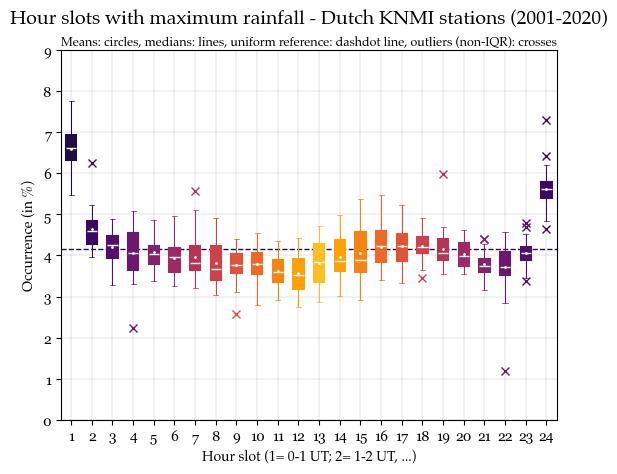

<Figure size 7200x4800 with 0 Axes>

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

df_h_list = []

# Fetch KNMI data year by year to prevent service overflow
for yr in range(2001, 2021):
    df_h_test = (knmi_meteo_transform
                 .knmi_hourslot_percentage_df(start_date=datetime.date(yr, 1, 1), 
                                              end_date=datetime.date(yr, 12, 31),
                                              return_as_counts=True))
    df_h_list.append(df_h_test)

# Use a reduce function to sum all count-dfs from the result list at once
df_h_cts = reduce(lambda x, y: x.add(y, fill_value=0), df_h_list)

# Convert the summed counts to percentages (apply over columns)
df_h = df_h_cts.apply(lambda x: 100 * x / x.sum(), axis=1)

# Create boxplot of maximum rainfall occurrence per hour slot
title_txt = "Hour slots with maximum rainfall - Dutch KNMI stations (2001-2020)"
subtitle_txt = ("Means: circles, medians: lines, uniform reference: dashdot line,"
                " outliers (non-IQR): crosses")

ax = knmi_meteo_visualize.cyclic_hourslot_boxplot(df_h, title_text=title_txt,
                                                  subtitle_text=subtitle_txt)

# Set high-quality DPI for optimal sharpness
fig = plt.figure(figsize=(12, 8), dpi=600)
fig.axes.append(ax)

# Finally, show the plot
plt.show()


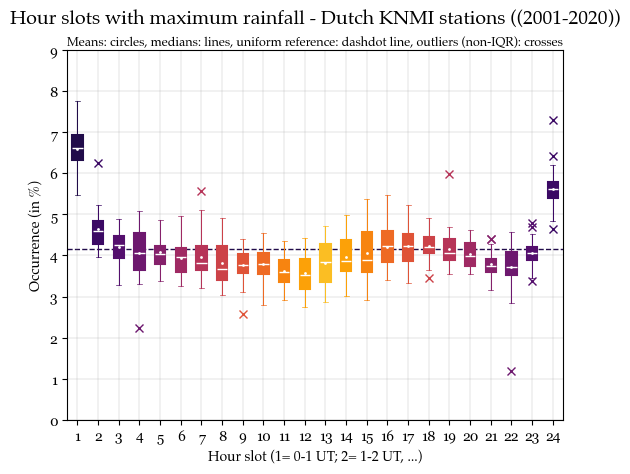

<Figure size 7200x4800 with 0 Axes>

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

YEAR_START, YEAR_END = 2001, 2020

# Fetch KNMI data year by year to prevent service overflow
df_h_slots = knmi_meteo_transform.get_multiyr_hourslot_percentages(
    year_start=YEAR_START, year_end=YEAR_END)

# Create boxplot of maximum rainfall occurrence per hour slot
title_txt = f"Hour slots with maximum rainfall - Dutch KNMI stations (({YEAR_START}-{YEAR_END}))"
subtitle_txt = ("Means: circles, medians: lines, uniform reference: dashdot line,"
                " outliers (non-IQR): crosses")

ax = knmi_meteo_visualize.cyclic_hourslot_boxplot(df_h_slots, 
                                                  title_text=title_txt,
                                                  subtitle_text=subtitle_txt)

# Set high-quality DPI for optimal sharpness
fig = plt.figure(figsize=(12, 8), dpi=600)
fig.axes.append(ax)

# Finally, show the plot
plt.show()

### Example 1.3: Maximum temperature hour slot pattern (2001-2020)

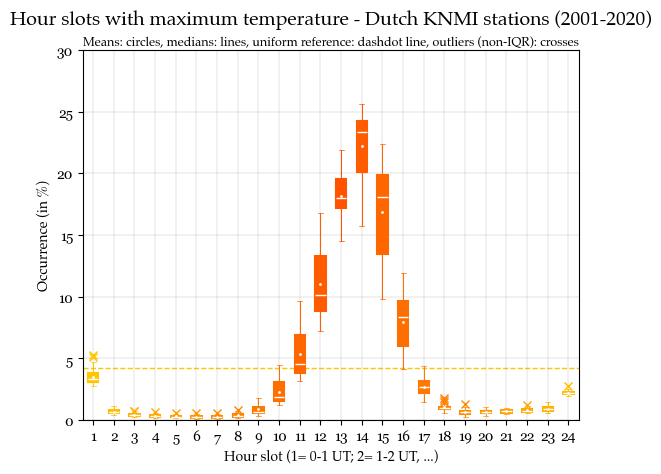

<Figure size 9000x6000 with 0 Axes>

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

YEAR_START, YEAR_END = 2001, 2020

df_h_slots = knmi_meteo_transform.get_multiyr_hourslot_percentages(
    year_start=YEAR_START, year_end=YEAR_END,
    param_col="max_temp", hourslot_col="hour_slot_max_temp")

title_txt = f"Hour slots with maximum temperature - Dutch KNMI stations ({YEAR_START}-{YEAR_END})"
subtitle_txt = ("Means: circles, medians: lines, uniform reference: dashdot line,"
                " outliers (non-IQR): crosses")

ax = knmi_meteo_visualize.cyclic_hourslot_boxplot(df_h_slots, title_text=title_txt,
                                                  subtitle_text=subtitle_txt,
                                                  cmap_name_a="autumn_r", cmap_name_b="autumn_r",
                                                  c_min=0.225, c_max=0.675)

# Set high-quality DPI for optimal sharpness
fig = plt.figure(figsize=(15, 10), dpi=600)
fig.axes.append(ax)

# Finally, show the plot
plt.show()

### Example 1.4: Maximum average wind speed hour slot pattern (2001-2020)

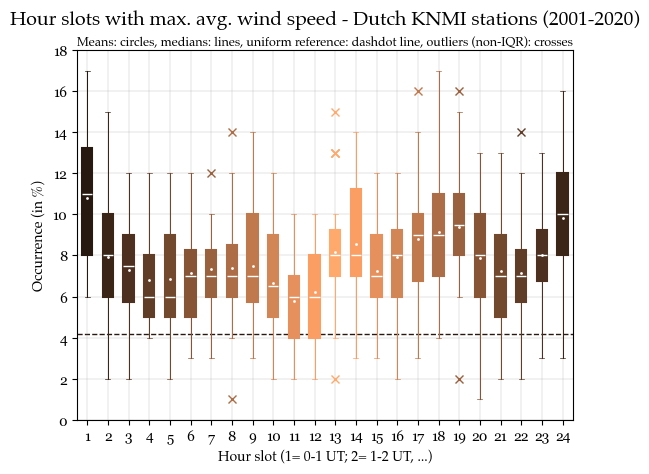

<Figure size 9000x6000 with 0 Axes>

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

YEAR_START, YEAR_END = 2001, 2020

df_h_slots = knmi_meteo_transform.get_multiyr_hourslot_percentages(
    year_start=YEAR_START, year_end=YEAR_END,
    param_col="max_hour_avg_wind_speed",
    hourslot_col="hour_slot_max_avg_wind_speed")

title_txt = f"Hour slots with max. avg. wind speed - Dutch KNMI stations ({YEAR_START}-{YEAR_END})"
subtitle_txt = ("Means: circles, medians: lines, uniform reference: dashdot line,"
                " outliers (non-IQR): crosses")

ax = knmi_meteo_visualize.cyclic_hourslot_boxplot(df_h_test, title_text=title_txt,
                                                   subtitle_text=subtitle_txt,
                                                   cmap_name_a="copper", cmap_name_b="copper")

# Set high-quality DPI for optimal sharpness
fig = plt.figure(figsize=(15, 10), dpi=600)
fig.axes.append(ax)

# Finally, show the plot
plt.show()

## Section 2: Kriging-based visualizations

### Example 2.1: Spatial distribution of Dutch sunshine in a given year

In [3]:
YEAR = 2023

# Set start and end dates (inclusive) for data retrieval
start_date = datetime.date(YEAR, 1, 1)
end_date = datetime.date(YEAR, 12, 31)

# Optional: uncomment below to make end_date exclusive
# end_date -= datetime.timedelta(days=1)


In [4]:
# Get irradiance data from KNMI web script service
df_irrad_raw = knmi_meteo_ingest.knmi_meteo_to_df(meteo_stns_list=None,
                                                  meteo_params_list=["Q"],
                                                  start_date=start_date,
                                                  end_date=end_date)

In [5]:
# Show the result
df_irrad_raw

,STN,YYYYMMDD,Q
0,209,20230101,NaN
1,209,20230102,NaN
2,209,20230103,NaN
3,209,20230104,NaN
4,209,20230105,NaN
...,...,...,...
17150,391,20231227,124.0
17151,391,20231228,182.0
17152,391,20231229,98.0
17153,391,20231230,178.0


In [6]:
# Apply transformations to clean the raw dataset
df_irrad = knmi_meteo_transform.transform_param_values(df_irrad_raw)

In [7]:
# Show the result
df_irrad

,station_code,date,global_irradiance
0,209,2023-01-01,NaN
1,209,2023-01-02,NaN
2,209,2023-01-03,NaN
3,209,2023-01-04,NaN
4,209,2023-01-05,NaN
...,...,...,...
17150,391,2023-12-27,124.0
17151,391,2023-12-28,182.0
17152,391,2023-12-29,98.0
17153,391,2023-12-30,178.0


In [8]:
# Pivot data with 'date' as index, 'stn_code' as cols
df_irrad_pivot = (df_irrad
                  .pivot(index="date",
                         columns="station_code"))

# Flatten pivot table to single index
df_irrad_pivot.columns = (df_irrad_pivot.columns
                          .get_level_values(1))


In [9]:
# Show the result
df_irrad_pivot

station_code,209,215,225,235,240,242,248,249,251,257,...,343,344,348,350,356,370,375,377,380,391
date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,NaN,221.0,NaN,222.0,218.0,NaN,NaN,196.0,224.0,203.0,...,NaN,182.0,203.0,151.0,184.0,165.0,177.0,212.0,145.0,116.0
2023-01-02,NaN,155.0,NaN,169.0,143.0,NaN,NaN,146.0,177.0,148.0,...,NaN,147.0,151.0,128.0,139.0,147.0,135.0,152.0,133.0,149.0
2023-01-03,NaN,177.0,NaN,125.0,129.0,NaN,NaN,123.0,128.0,121.0,...,NaN,166.0,140.0,147.0,140.0,140.0,148.0,225.0,251.0,157.0
2023-01-04,NaN,129.0,NaN,163.0,123.0,NaN,NaN,146.0,152.0,128.0,...,NaN,137.0,135.0,79.0,116.0,79.0,89.0,91.0,66.0,72.0
2023-01-05,NaN,249.0,NaN,200.0,215.0,NaN,NaN,207.0,237.0,210.0,...,NaN,222.0,239.0,222.0,284.0,209.0,230.0,247.0,174.0,206.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,NaN,58.0,NaN,42.0,58.0,NaN,NaN,47.0,49.0,57.0,...,NaN,82.0,72.0,122.0,92.0,132.0,110.0,162.0,170.0,124.0
2023-12-28,NaN,164.0,NaN,156.0,147.0,NaN,NaN,174.0,135.0,199.0,...,NaN,159.0,195.0,240.0,209.0,187.0,188.0,225.0,289.0,182.0
2023-12-29,NaN,162.0,NaN,154.0,177.0,NaN,NaN,156.0,210.0,148.0,...,NaN,175.0,176.0,145.0,154.0,108.0,126.0,106.0,133.0,98.0


In [10]:
# Show counts of % of missing data for the stations
(df_irrad_pivot.isnull().mean() * 100).value_counts()

0.0      32
100.0    15
Name: count, dtype: int64

Great! The irradiance data is either fully available or fully absent per station for our sample year (2023). This underlines again how good the quality of the KNMI dataset actually is. 

However, let's still put a filter on our DataFrame to always only keep stations having less than 1% of missing data, just to be safe. 

Note that we set the requirement for data completion much stricter here than in the previous hour slot-based section (10% missing data allowed there). 

This is because now our data is highly seasonally variable, meaning that the impact of just a few missing values can already be substantial. Also, we are now aiming to highlight (potentially subtle) spatial variations as fairly and completely as possible, compared to working with averages over all stations in the previous section.

In [11]:
# Only keep stations with <1% of missing data days
filter_cond = df_irrad_pivot.isnull().mean() < .01
df_irrad_sel = df_irrad_pivot.loc[:, filter_cond]

In [12]:
# Show shape of remaining dataset
print(f"Rows (periods): {df_irrad_sel.shape[0]} | "
      f"Cols (stations): {df_irrad_sel.shape[1]}")

Rows (periods): 365 | Cols (stations): 32


In [13]:
# Now, convert J/cm2 to kWh/m2 and sum to totals
conv_to_kwh_m2 = 1 / 360
df_solar = (df_irrad_sel.sum() 
            * conv_to_kwh_m2).round(1)

# Convert pd.Series to pd.DataFrame
df_solar = (df_solar.to_frame(name="global_irrad")
            .reset_index())

In [14]:
# Show the results in kWh/m2
df_solar

,station_code,global_irrad
0,215,1144.6
1,235,1145.3
2,240,1125.8
3,249,1123.0
4,251,1157.8
5,257,1138.8
6,260,1095.8
7,267,1132.4
8,269,1111.9
9,270,1100.3


In [15]:
# Get cleaned station (meta)data for adding lon, lat-data
df_stns = knmi_meteo_ingest.knmi_load_meteo_stations()
df_stns = knmi_meteo_transform.transform_stations(df_stns)

df_stns

,station_code,longitude,latitude,altitude,location_name
0,209,4.518,52.465,0.0,IJmond
1,210,4.430,52.171,-0.2,Valkenburg Zh
2,215,4.437,52.141,-1.1,Voorschoten
3,225,4.555,52.463,4.4,IJmuiden
4,235,4.781,52.928,1.2,De Kooy
5,240,4.790,52.318,-3.3,Schiphol
6,242,4.921,53.241,10.8,Vlieland
7,248,5.174,52.634,0.8,Wijdenes
8,249,4.979,52.644,-2.4,Berkhout
9,251,5.346,53.392,0.7,Hoorn Terschelling


In [16]:
# Merge station location (meta)data to our results
df_solar_stns = df_solar.merge(df_stns, how="left", 
                               on="station_code")
df_solar_stns

,station_code,global_irrad,longitude,latitude,altitude,location_name
0,215,1144.6,4.437,52.141,-1.1,Voorschoten
1,235,1145.3,4.781,52.928,1.2,De Kooy
2,240,1125.8,4.790,52.318,-3.3,Schiphol
3,249,1123.0,4.979,52.644,-2.4,Berkhout
4,251,1157.8,5.346,53.392,0.7,Hoorn Terschelling
5,257,1138.8,4.603,52.506,8.5,Wijk aan Zee
6,260,1095.8,5.180,52.100,1.9,De Bilt
7,267,1132.4,5.384,52.898,-1.3,Stavoren
8,269,1111.9,5.520,52.458,-3.7,Lelystad
9,270,1100.3,5.752,53.224,1.2,Leeuwarden


In [17]:
# Convert columns of interest to NumPy arrays
stations_x = df_solar_stns["longitude"].to_numpy()
stations_y = df_solar_stns["latitude"].to_numpy()
values = df_solar_stns["global_irrad"].to_numpy()

print("Longitudes: ", stations_x)
print("Latitudes: ", stations_y)
print("Values: ", values)

Longitudes:  [4.437 4.781 4.79  4.979 5.346 4.603 5.18  5.384 5.52  5.752 5.888 5.873
 6.2   6.259 6.574 6.585 6.657 7.15  6.891 3.596 3.861 3.884 4.122 4.447
 4.926 4.936 5.146 5.377 5.707 5.763 5.762 6.197]
Latitudes:  [52.141 52.928 52.318 52.644 53.392 52.506 52.1   52.898 52.458 53.224
 52.703 52.056 53.413 52.435 52.75  53.125 52.069 53.196 52.274 51.442
 51.226 51.527 51.992 51.962 51.97  51.566 51.859 51.451 51.659 51.198
 50.906 51.498]
Values:  [1144.6 1145.3 1125.8 1123.  1157.8 1138.8 1095.8 1132.4 1111.9 1100.3
 1091.4 1080.7 1117.2 1098.1 1079.7 1088.4 1110.5 1081.4 1091.9 1192.3
 1119.4 1168.8 1160.4 1111.2 1130.3 1107.8 1130.  1119.5 1121.5 1127.5
 1119.9 1093.9]


In [18]:
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from mpl_toolkits.basemap import Basemap

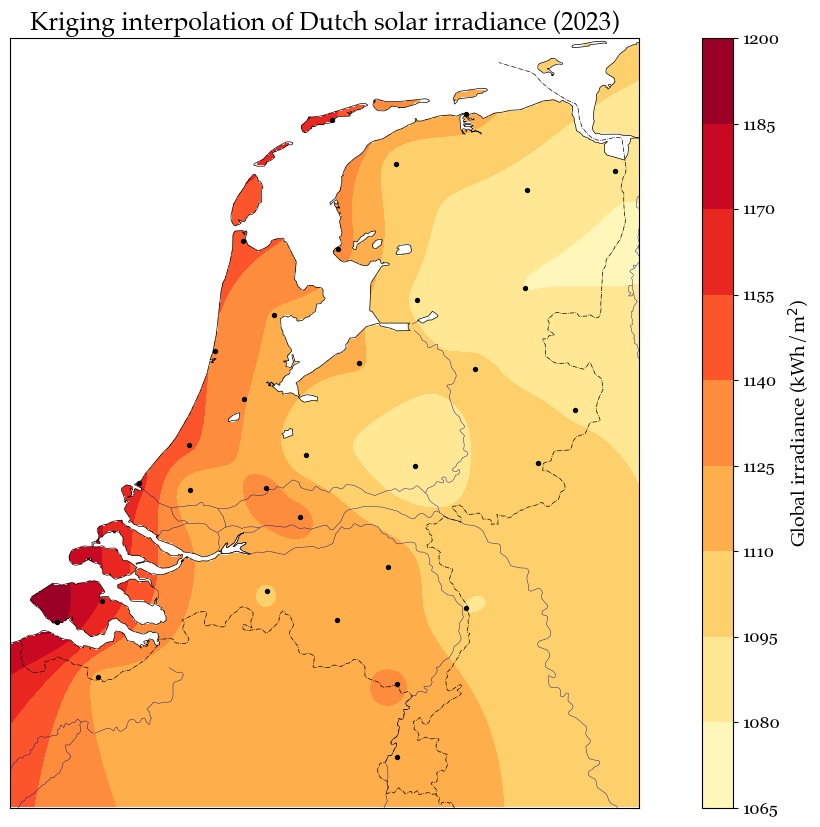

In [19]:
%matplotlib inline
textfont = {"fontname": "Palatino"}
tickfont = {"fontname": "Georgia",
            "size": 12}

# Create grid for geospatial interpolation
min_x, max_x = 3.0, 8.0
min_y, max_y = 50.0, 54.0
grid_dim_xy = 500
vg_model = "linear"
colormap = "YlOrRd"

grid_x, grid_y = np.meshgrid(np.linspace(min_x, max_x, grid_dim_xy, endpoint=True), 
                             np.linspace(min_y, max_y, grid_dim_xy, endpoint=True))

# Use OrdinaryKriging (2D-based) for interpolation
OK = OrdinaryKriging(stations_x, stations_y, values,
                     variogram_model=vg_model,
                     verbose=False, enable_plotting=False,
                     coordinates_type="geographic")

# Execute OK algorithm to fill grid with interpolation values
grid_z, ss = OK.execute("grid", grid_x[0, :], grid_y[:, 0])

# Set up figure for plotting
plt.figure(figsize=(15, 10))

# Create a Basemap for The Netherlands
m = Basemap(projection='merc', llcrnrlat=50.7, urcrnrlat=53.7, llcrnrlon=3.3, urcrnrlon=7.3, resolution='h')
m.drawcountries(linewidth=0.5, linestyle='-.', color='k')
m.drawrivers(linewidth=0.3, linestyle='solid', color='darkblue')
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='k')

# Convert grid coordinates to map projection coordinates
x, y = m(grid_x, grid_y)

# Mask values outside land borders using the Basemap land-sea mask
land_mask = np.vectorize(m.is_land)(x, y)
land_grid_z = np.ma.masked_where(np.logical_not(land_mask), grid_z)

# Plot interpolated values
cs = m.contourf(x, y, land_grid_z, cmap=colormap)

# Add color bar
cbar = m.colorbar(cs, location='right', pad="10%")
cbar.set_label("Global irradiance (kWh/m$^{2}$)", fontsize=14, **textfont)

# Plot station locations on map
stn_x, stn_y = m(stations_x, stations_y)
m.scatter(stn_x, stn_y, color="k", marker="o", s=8)

# Customize font of the colorbar's tick markers
cbar.ax.set_yticks(cbar.ax.get_yticks(), cbar.ax.get_yticklabels(), 
                   **tickfont)
cbar.ax.set_xticks(cbar.ax.get_xticks(), cbar.ax.get_xticklabels(), 
                   **tickfont)

plt.title(f"Kriging interpolation of Dutch solar irradiance ({YEAR})", 
          fontsize=18, **textfont)
plt.show()

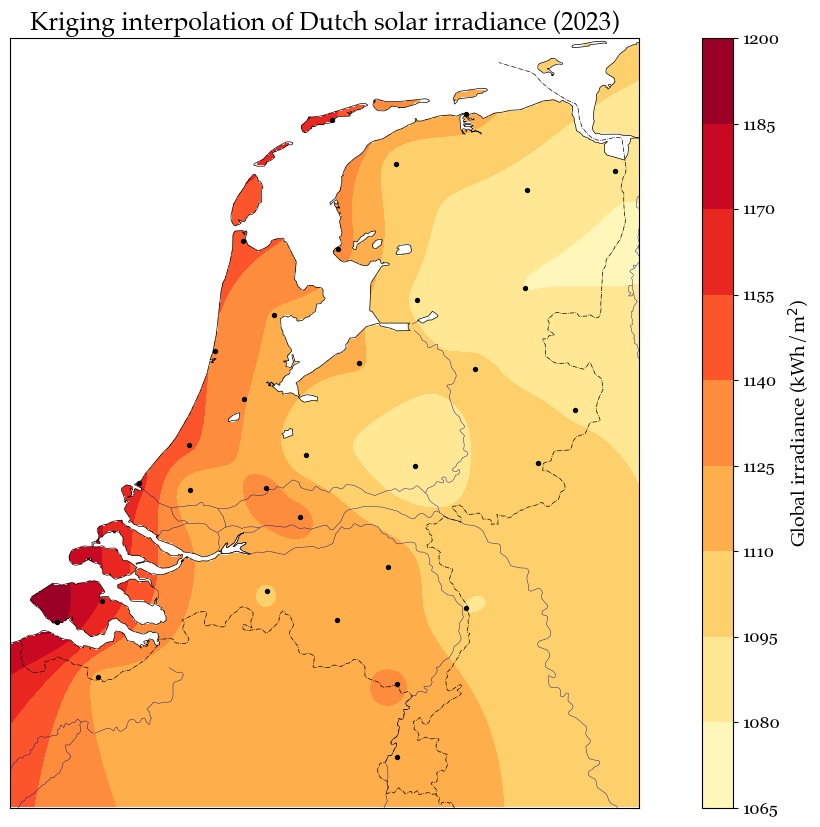

In [ ]:
%matplotlib inline
# Define figure dimensions
fig = plt.figure(figsize=(15, 10), dpi=600)

ax = knmi_meteo_visualize.ordinary_kriging_nl_plot(
    stations_x, stations_y, values,
    plot_title=f"Kriging interpolation of Dutch solar irradiance ({YEAR})",
    val_label = "Global irradiance (kWh/m$^{2}$)"
)

fig.axes.append(ax)

# Show the plot
plt.show()

In [21]:
print(fig)